<a href="https://colab.research.google.com/github/akm2208/PCA-Analysis/blob/main/Sovereign_Default_PCA_Attempt_2%2C_Apr_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#Step 1

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# ---------------------------------------
# Step 1.1: Load the Historic Climate Data
# ---------------------------------------
# Adjust the file path as needed
historic = pd.read_csv('historic_climate.csv')

# ---------------------------------------
# Step 1.2: Select the Climate Variables for PCA
# ---------------------------------------
# We use variables that capture temperature exposure, deaths, and economic losses.
climate_vars = [
    'cld_excess_mortality',       # Cold-related deaths
    'cld_heating_degree_days',    # Cold exposure proxy
    'hsa_killing_degree_days',    # Heatwave proxy (extreme events)
    'hsi_cooling_degree_days',    # Heat exposure proxy
    'hsi_excess_mortality',       # Heat-related deaths
    'hsw_gdp_loss',               # GDP loss because of heat stress (%)
    'hsw_productivity_loss'       # Labor productivity loss because of heat (%)
]

X = historic[climate_vars]

# ---------------------------------------
# Step 1.3: Standardize the Data
# ---------------------------------------
# Standardization ensures each variable contributes equally.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------
# Step 1.4: Run PCA to Extract the First Principal Component
# ---------------------------------------
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X_scaled)

# Create a DataFrame for the PCA results and keep the country code for merging later
pca_df = pd.DataFrame(pc1, columns=['PC1'])
pca_df['iso3'] = historic['iso3']



In [29]:
# Try printing before scaling
print("Before scaling:")
print(pca_df['PC1'].describe())

# Redo scaling
minmax_scaler = MinMaxScaler(feature_range=(0, 5))
pca_df['PCA_climate_score'] = minmax_scaler.fit_transform(pca_df[['PC1']])

# Check again
print("After scaling:")
print(pca_df['PCA_climate_score'].describe())

Before scaling:
count    2.420000e+02
mean     8.808381e-17
std      2.095174e+00
min     -4.216542e+00
25%     -1.958126e+00
50%      1.774926e-01
75%      1.679795e+00
max      4.908235e+00
Name: PC1, dtype: float64
After scaling:
count    242.000000
mean       2.310490
std        1.148068
min        0.000000
25%        1.237518
50%        2.407749
75%        3.230948
max        5.000000
Name: PCA_climate_score, dtype: float64


In [30]:
# ---------------------------------------
# Step 1.5: Normalize the PC1 Score to a 0-5 Range
# ---------------------------------------
# This step rescales the PCA score to align with ICE's climate score.
minmax_scaler = MinMaxScaler(feature_range=(0, 5))
pca_df['PCA_climate_score'] = minmax_scaler.fit_transform(pca_df[['PC1']])

# Preview the first few rows of the resulting DataFrame
print(pca_df.head())

        PC1 iso3  PCA_climate_score
0 -2.786426  AFG           0.783645
1 -1.966710  ALB           1.232815
2 -1.307261  DZA           1.594165
3  1.327854  ASM           3.038099
4 -2.703548  AND           0.829058


In [31]:
# Step 2

# Step 2.1 Collapse lagged data to one row per country using mean 5-year score
lagged_avg = lagged.groupby('iso3', as_index=False)['5yr_avg_climate_score'].mean()

# Step 2.2 Now merge with PCA climate score
combined = pd.merge(lagged_avg, pca_df[['iso3', 'PCA_climate_score']], on='iso3', how='inner')

# Step 2.3 Check result
print(combined.head())

  iso3  5yr_avg_climate_score  PCA_climate_score
0  AFG               0.033272           0.783645
1  AGO               1.402257           2.007097
2  ALB               0.469348           1.232815
3  AND               0.071045           0.829058
4  ARE               2.464719           3.403683


  iso3  PCA_climate_score  5yr_avg_climate_score
0  AFG           0.783645               0.033272
1  AGO           2.007097               1.402257
2  ALB           1.232815               0.469348
3  AND           0.829058               0.071045
4  ARE           3.403683               2.464719


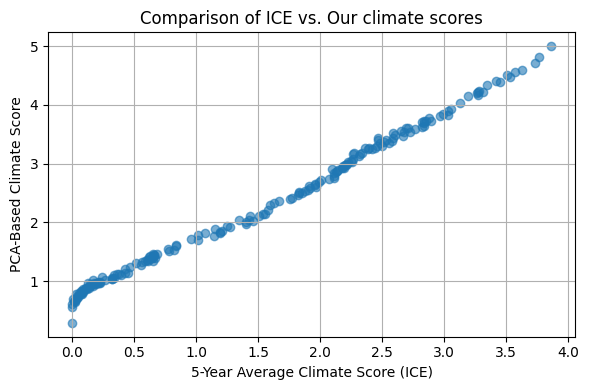

In [32]:
# Step 2.4  Load the lagged full data
lagged = pd.read_csv('lagged_full_data.csv')

# Step 2.5 Collapse lagged data to one row per country using mean 5-year score
lagged_avg = lagged.groupby('iso3', as_index=False)['5yr_avg_climate_score'].mean()

# Step 2.6 Merge with the PCA scores using iso3 code
combined = pd.merge(lagged_avg, pca_df[['iso3', 'PCA_climate_score']], on='iso3', how='inner')

# Step 2.7 Drop rows with missing values
combined_clean = combined.dropna(subset=['PCA_climate_score', '5yr_avg_climate_score'])

# Step 2.8 Print a sample
print(combined_clean[['iso3', 'PCA_climate_score', '5yr_avg_climate_score']].head())

# Step 2.9 Plot the comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(combined_clean['5yr_avg_climate_score'], combined_clean['PCA_climate_score'], alpha=0.6)
plt.xlabel('5-Year Average Climate Score (ICE)')
plt.ylabel('PCA-Based Climate Score')
plt.title('Comparison of ICE vs. Our climate scores')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Step 2.10 Pearson correlation
#Remember, PCA_climate score is ours, 5-year ones is ICE's score
correlation = combined_clean[['PCA_climate_score', '5yr_avg_climate_score']].corr(method='pearson')
print(correlation)

                       PCA_climate_score  5yr_avg_climate_score
PCA_climate_score               1.000000               0.997423
5yr_avg_climate_score           0.997423               1.000000


In [37]:
# Step 3

#Step 3.1 Merge PCA climate score into lagged_full_data

# Merge PCA-based climate score into lagged_full_data
merged_df = pd.merge(lagged, pca_df[['iso3', 'PCA_climate_score']], on='iso3', how='left')

# Drop rows with missing values in any key columns
model_df = merged_df.dropna(subset=[
    'PCA_climate_score',
    '5yr_avg_inflation',
    '5yr_avg_financial_dev',
    '5yr_avg_debt_to_gdp',
    '5yr_avg_gdp_deflator',
    '5yr_avg_gdp_growth',
    '5yr_avg_REER',
    '5yr_avg_terms_of_trade_index',
    'is_default'
])

# Step 3.2 Rename variables for clarity
model_df = model_df.rename(columns={
    '5yr_avg_inflation': 'inflation',
    '5yr_avg_financial_dev': 'finance',
    '5yr_avg_debt_to_gdp': 'debt_gdp',
    '5yr_avg_gdp_deflator': 'gdp_deflator',
    '5yr_avg_gdp_growth': 'gdp_growth',
    '5yr_avg_REER': 'reer',
    '5yr_avg_terms_of_trade_index': 'terms_trade',
    'PCA_climate_score': 'climate_score'
})

In [38]:
# Step 3.3 Split into train and test

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(model_df, test_size=0.3, random_state=42)

#Step 3.4 run baseline and extended logistic regression models

import statsmodels.formula.api as smf

# Baseline model (economic variables only)
baseline_formula = 'is_default ~ inflation + finance + debt_gdp + gdp_deflator + gdp_growth + reer + terms_trade'
baseline_model = smf.logit(formula=baseline_formula, data=train_df).fit()

# Extended model (adds climate score)
extended_formula = baseline_formula + ' + climate_score'
extended_model = smf.logit(formula=extended_formula, data=train_df).fit()

# Summarize results
print("=== Baseline Model ===")
print(baseline_model.summary())
print("\n=== Extended Model ===")
print(extended_model.summary())

Optimization terminated successfully.
         Current function value: 0.550727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.546042
         Iterations 8
=== Baseline Model ===
                           Logit Regression Results                           
Dep. Variable:             is_default   No. Observations:                 3530
Model:                          Logit   Df Residuals:                     3522
Method:                           MLE   Df Model:                            7
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.2039
Time:                        17:27:18   Log-Likelihood:                -1944.1
converged:                       True   LL-Null:                       -2441.9
Covariance Type:            nonrobust   LLR p-value:                1.033e-210
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [40]:
import statsmodels.api as sm

# Assuming 'model_extended' is your fitted Logit model
marginal_effects = extended_model.get_margeff()
print(marginal_effects.summary())

#dy/dx tells you the average marginal effect — that is:
#How much the probability of default changes when the climate score increases by 1 unit, holding everything else constant.
#A 1-unit increase in the climate score leads to a 3.81 percentage point increase in the predicted probability of sovereign default.

        Logit Marginal Effects       
Dep. Variable:             is_default
Method:                          dydx
At:                           overall
                   dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflation         0.0003      0.000      1.144      0.253      -0.000       0.001
finance          -0.0062      0.000    -25.033      0.000      -0.007      -0.006
debt_gdp          0.0003      0.000      0.975      0.329      -0.000       0.001
gdp_deflator      0.0005      0.000      2.061      0.039    2.47e-05       0.001
gdp_growth        0.0026      0.002      1.255      0.210      -0.001       0.007
reer              0.0007      0.000      1.524      0.127      -0.000       0.002
terms_trade       0.0005      0.000      2.012      0.044    1.24e-05       0.001
climate_score     0.0381      0.007      5.838      0.000       0.025       0.051


In [41]:
#Step 5
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
baseline_probs = baseline_model.predict(test_df)
extended_probs = extended_model.predict(test_df)

# AUC score
baseline_auc = roc_auc_score(test_df['is_default'], baseline_probs)
extended_auc = roc_auc_score(test_df['is_default'], extended_probs)

print("Baseline AUC:", round(baseline_auc, 4))
print("Extended AUC:", round(extended_auc, 4))

Baseline AUC: 0.7987
Extended AUC: 0.7988


In [42]:
#Step 5 continued
# Pseudo R² and Log-likelihood
print("Baseline Pseudo R²:", round(baseline_model.prsquared, 4))
print("Extended Pseudo R²:", round(extended_model.prsquared, 4))

print("Baseline Log-Likelihood:", round(baseline_model.llf, 2))
print("Extended Log-Likelihood:", round(extended_model.llf, 2))

# AIC
print("Baseline AIC:", round(baseline_model.aic, 2))
print("Extended AIC:", round(extended_model.aic, 2))

Baseline Pseudo R²: 0.2039
Extended Pseudo R²: 0.2106
Baseline Log-Likelihood: -1944.07
Extended Log-Likelihood: -1927.53
Baseline AIC: 3904.13
Extended AIC: 3873.06


In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# Convert predicted probabilities to binary using a 0.5 threshold
baseline_preds = (baseline_probs >= 0.5).astype(int)
extended_preds = (extended_probs >= 0.5).astype(int)

# Confusion matrix and classification report
print("=== Baseline Confusion Matrix ===")
print(confusion_matrix(test_df['is_default'], baseline_preds))
print(classification_report(test_df['is_default'], baseline_preds))

print("\n=== Extended Confusion Matrix ===")
print(confusion_matrix(test_df['is_default'], extended_preds))
print(classification_report(test_df['is_default'], extended_preds))

=== Baseline Confusion Matrix ===
[[442 280]
 [154 638]]
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       722
           1       0.69      0.81      0.75       792

    accuracy                           0.71      1514
   macro avg       0.72      0.71      0.71      1514
weighted avg       0.72      0.71      0.71      1514


=== Extended Confusion Matrix ===
[[449 273]
 [150 642]]
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       722
           1       0.70      0.81      0.75       792

    accuracy                           0.72      1514
   macro avg       0.73      0.72      0.72      1514
weighted avg       0.72      0.72      0.72      1514



In [46]:
#Step 5

# Step 5.1: Load and preview future climate data
future = pd.read_csv('future_climate.csv')
print(future.columns)           # Check column names
print(future['scenario'].unique())  # Check available scenarios
print(future.head())            # Peek at data

# Step 5.2: Check number of non-null rows for SSP5-8.5
ssp5 = future[future['scenario'] == 'SSP5-8.5']
print("Rows before dropna:", ssp5.shape[0])
print("Rows after dropna:", ssp5.dropna(subset=climate_vars).shape[0])

Index(['country_name', 'iso3', 'scenario', 'year', 'cld_excess_mortality',
       'cld_heating_degree_days', 'hsa_killing_degree_days',
       'hsi_cooling_degree_days', 'hsi_excess_mortality', 'hsw_gdp_loss',
       'hsw_productivity_loss'],
      dtype='object')
['ssp1_26' 'ssp3_70' 'ssp5_85']
  country_name iso3 scenario  year  cld_excess_mortality  \
0  Afghanistan  AFG  ssp1_26  2020               603.800   
1  Afghanistan  AFG  ssp1_26  2021               602.335   
2  Afghanistan  AFG  ssp1_26  2022               600.870   
3  Afghanistan  AFG  ssp1_26  2023               599.405   
4  Afghanistan  AFG  ssp1_26  2024               597.940   

   cld_heating_degree_days  hsa_killing_degree_days  hsi_cooling_degree_days  \
0                  3687.10                    0.400                   885.90   
1                  3676.59                    0.415                   889.38   
2                  3666.08                    0.430                   892.86   
3                  365

In [53]:
#Step 5.3
ssp5 = future[future['scenario'] == 'ssp5_85']

In [54]:
#Step 5.4
print("Rows before dropna:", ssp5.shape[0])
print("Rows after dropna:", ssp5.dropna(subset=climate_vars).shape[0])

Rows before dropna: 19602
Rows after dropna: 19602


In [55]:
#Step 5.5
# Use the same 7 variables
climate_vars = [
    'cld_excess_mortality',
    'cld_heating_degree_days',
    'hsa_killing_degree_days',
    'hsi_cooling_degree_days',
    'hsi_excess_mortality',
    'hsw_gdp_loss',
    'hsw_productivity_loss'
]

# Standardize using the scaler from historic data
ssp5_scaled = scaler.transform(ssp5[climate_vars])  # use the same 'scaler' from Step 1.3

# Transform using historic PCA
ssp5_pc1 = pca.transform(ssp5_scaled)

# Normalize to ICE 0–5 scale using same minmax scaler
ssp5.loc[:, 'PCA_climate_score'] = minmax_scaler.transform(ssp5_pc1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
<ipython-input-55-d44374e018df>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssp5.loc[:, 'PCA_climate_score'] = minmax_scaler.transform(ssp5_pc1)


In [57]:
# Copy average values for economic vars from training data
mean_vals = train_df[['inflation', 'finance', 'debt_gdp', 'gdp_deflator', 'gdp_growth', 'reer', 'terms_trade']].mean()

# Predict for each row in SSP5
ssp5_input = ssp5_input.rename(columns={'PCA_climate_score': 'climate_score'})

# Add average economic controls
for col in mean_vals.index:
    ssp5_input[col] = mean_vals[col]

# Predict default probability
ssp5_input['predicted_default_prob'] = extended_model.predict(ssp5_input[[
    'inflation', 'finance', 'debt_gdp', 'gdp_deflator',
    'gdp_growth', 'reer', 'terms_trade', 'climate_score'
]])

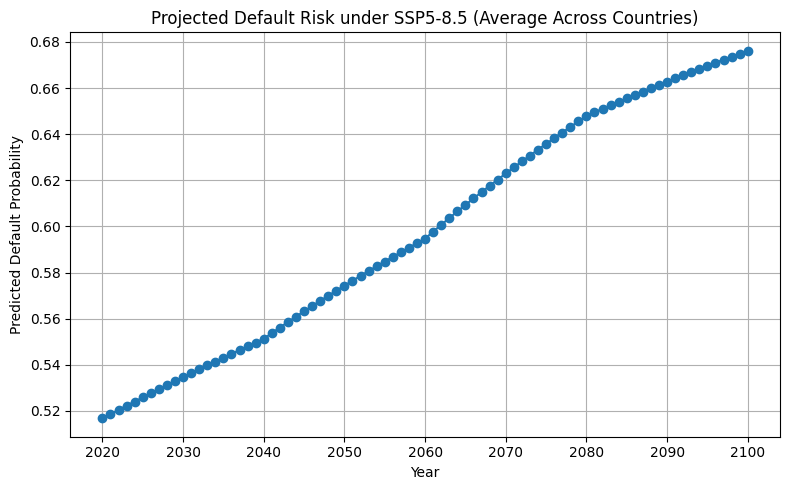

In [58]:
# Group by year and average predicted default probability
trend = ssp5_input.groupby('year')['predicted_default_prob'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['predicted_default_prob'], marker='o')
plt.title('Projected Default Risk under SSP5-8.5 (Average Across Countries)')
plt.xlabel('Year')
plt.ylabel('Predicted Default Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

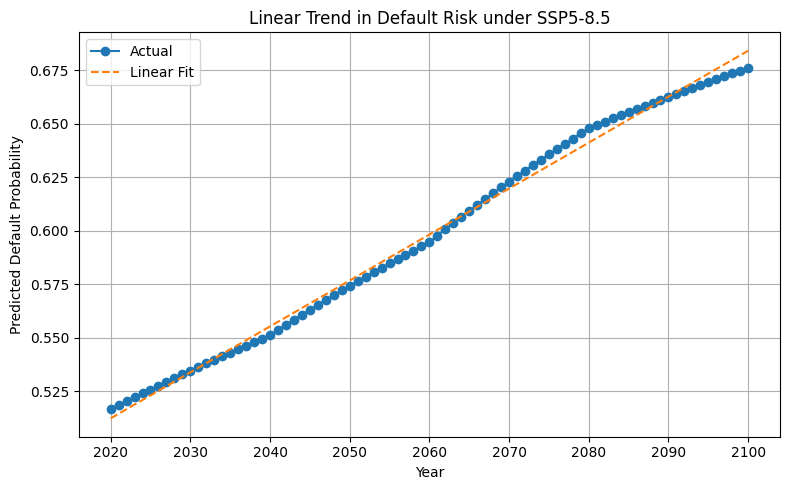

                              OLS Regression Results                              
Dep. Variable:     predicted_default_prob   R-squared:                       0.995
Model:                                OLS   Adj. R-squared:                  0.995
Method:                     Least Squares   F-statistic:                 1.576e+04
Date:                    Tue, 01 Apr 2025   Prob (F-statistic):           1.04e-92
Time:                            18:37:06   Log-Likelihood:                 341.85
No. Observations:                      81   AIC:                            -679.7
Df Residuals:                          79   BIC:                            -674.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [60]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Linear regression of predicted default probability over time
X = ssp5_input['year']
y = ssp5_input['predicted_default_prob']

# Group by year to get the average trend (if not already grouped)
trend = ssp5_input.groupby('year')['predicted_default_prob'].mean().reset_index()

# Linear regression
X_trend = sm.add_constant(trend['year'])  # Add intercept
y_trend = trend['predicted_default_prob']

model = sm.OLS(y_trend, X_trend).fit()

# Add predictions to plot
trend['linear_fit'] = model.predict(X_trend)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['predicted_default_prob'], label='Actual', marker='o')
plt.plot(trend['year'], trend['linear_fit'], label='Linear Fit', linestyle='--')
plt.title('Linear Trend in Default Risk under SSP5-8.5')
plt.xlabel('Year')
plt.ylabel('Predicted Default Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print regression summary
print(model.summary())

In [61]:
import plotly.express as px

# Step 1: Filter for the year 2080 and select relevant columns
ssp5_map_df = ssp5_input[ssp5_input['year'] == 2080][['iso3', 'predicted_default_prob']].copy()

# Step 2: Drop any rows without predictions
ssp5_map_df = ssp5_map_df.dropna(subset=['predicted_default_prob'])

# Step 3: Plot with Plotly
fig = px.choropleth(
    ssp5_map_df,
    locations='iso3',
    color='predicted_default_prob',
    color_continuous_scale='Reds',
    projection='natural earth',
    title='Projected Sovereign Default Risk in 2080 (SSP5-8.5 Scenario)',
    labels={'predicted_default_prob': 'Default Risk'},
    height=600
)

fig.update_geos(showframe=False, showcoastlines=False)
fig.update_layout(coloraxis_colorbar=dict(title="Default<br>Probability"))
fig.show()

In [63]:
# Step 0: Filter SSP1-2.6 from future climate dataset
ssp1 = future[future['scenario'] == 'ssp1_26'].copy()

# Step 1: Standardize climate variables using *historic* scaler
ssp1_scaled = scaler.transform(ssp1[climate_vars])  # Use scaler from Step 1.3
ssp1_pc1 = pca.transform(ssp1_scaled)               # Use PCA from Step 1.4

# Step 2: Rescale PCA score to match ICE's 0–5 scale
ssp1['PCA_climate_score'] = minmax_scaler.transform(ssp1_pc1)  # same MinMaxScaler from Step 1.5

# Step 3: Add mean economic variables (assumes you've defined `mean_vals` earlier)
for col in mean_vals.index:
    ssp1[col] = mean_vals[col]

# Step 4: Predict default probability using your extended model
ssp1_input = ssp1.copy()
ssp1_input = ssp1_input.rename(columns={'PCA_climate_score': 'climate_score'})  # match model input
ssp1_input['predicted_default_prob'] = extended_model.predict(ssp1_input[[
    'inflation', 'finance', 'debt_gdp', 'gdp_deflator', 'gdp_growth',
    'reer', 'terms_trade', 'climate_score'
]])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [64]:
ssp1_2080 = ssp1_input[ssp1_input['year'] == 2080][['iso3', 'predicted_default_prob']].copy()
ssp1_2080.rename(columns={'predicted_default_prob': 'default_prob_ssp1'}, inplace=True)

In [65]:
# Step 0: Filter SSP3-7.0 from future climate dataset
ssp3 = future[future['scenario'] == 'ssp3_70'].copy()

# Step 1: Standardize climate variables using *historic* scaler
ssp3_scaled = scaler.transform(ssp3[climate_vars])  # Use scaler from Step 1.3
ssp3_pc1 = pca.transform(ssp3_scaled)               # Use PCA from Step 1.4

# Step 2: Rescale PCA score to ICE’s 0–5 scale
ssp3['PCA_climate_score'] = minmax_scaler.transform(ssp3_pc1)  # Use same MinMaxScaler from Step 1.5

# Step 3: Add mean economic controls
for col in mean_vals.index:
    ssp3[col] = mean_vals[col]

# Step 4: Predict default probability using your extended model
ssp3_input = ssp3.copy()
ssp3_input = ssp3_input.rename(columns={'PCA_climate_score': 'climate_score'})  # match model input
ssp3_input['predicted_default_prob'] = extended_model.predict(ssp3_input[[
    'inflation', 'finance', 'debt_gdp', 'gdp_deflator', 'gdp_growth',
    'reer', 'terms_trade', 'climate_score'
]])
ssp3_2080 = ssp3_input[ssp3_input['year'] == 2080][['iso3', 'predicted_default_prob']].copy()
ssp3_2080.rename(columns={'predicted_default_prob': 'default_prob_ssp3'}, inplace=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [66]:
import plotly.graph_objects as go

# Step 1: Prepare SSP1 data for 2080
ssp1_2080 = ssp1_input[ssp1_input['year'] == 2080][['iso3', 'predicted_default_prob']].copy()
ssp1_2080 = ssp1_2080.dropna(subset=['predicted_default_prob'])
ssp1_2080.rename(columns={'predicted_default_prob': 'default_prob_ssp1'}, inplace=True)

# Step 2: Prepare SSP5 data for 2080
ssp5_2080 = ssp5_input[ssp5_input['year'] == 2080][['iso3', 'predicted_default_prob']].copy()
ssp5_2080 = ssp5_2080.dropna(subset=['predicted_default_prob'])
ssp5_2080.rename(columns={'predicted_default_prob': 'default_prob_ssp5'}, inplace=True)

# Step 3: Create figure with subplots
fig = go.Figure()

# Left plot (SSP1)
fig.add_trace(go.Choropleth(
    locations=ssp1_2080['iso3'],
    z=ssp1_2080['default_prob_ssp1'],
    colorscale='Reds',
    colorbar_title='SSP1<br>Default Risk',
    locationmode='ISO-3',
    zmin=0,
    zmax=1,
    name='SSP1',
    geo='geo'
))

# Right plot (SSP5)
fig.add_trace(go.Choropleth(
    locations=ssp5_2080['iso3'],
    z=ssp5_2080['default_prob_ssp5'],
    colorscale='Reds',
    showscale=False,  # Hide second colorbar
    locationmode='ISO-3',
    zmin=0,
    zmax=1,
    name='SSP5',
    geo='geo2'
))

# Layout with 2 maps side by side
fig.update_layout(
    title_text='Projected Sovereign Default Risk in 2080 (SSP1 vs SSP5)',
    geo=dict(domain=dict(x=[0, 0.48]), showframe=False, showcoastlines=False, projection_type='natural earth'),
    geo2=dict(domain=dict(x=[0.52, 1]), showframe=False, showcoastlines=False, projection_type='natural earth'),
    margin=dict(l=0, r=0, t=50, b=0),
    height=600
)

fig.show()